# Extracting Time Series at Multiple Polygons with Xarray

## Introduction

Zonal Statistics is used to summarize the values of a raster dataset within the zones of a vector dataset. We can also extend this process over time to extract data for mutliple time-steps. This requires we rasterize each polygon in the input vector for each time step. The [`regionmask`](https://regionmask.readthedocs.io/en/stable/) is a helpful library to create a 3D rasterized version of the zones.

This is a large computation that is enabled by cloud-hosted NightTime Lights data in the Cloud-Optimized GeoTIFF (COG) format and parallel computing on a local dask cluster.

## Overview of the Task

We select all Admin1 units of a country and calculate a sum of nighttime light pixel intensities over multiple years.


**Input Layers**:

* `ne_10m_admin_1_states_provinces.zip`: Admin-1 (States/Provinces) shapefile from Natural Earth
*  `2015.tif`, `2016.tif`, ... `2020.tif`: Yearly global rasters of nighttime light data. These files were download from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/YGIVCD) and converted to Cloud-Optimized GeoTIFFs using GDAL.

    *Example command:*

    ```
    gdalwarp -of COG 2021_HasMask/LongNTL_2021.tif 2021.tif \
      -te -180 -90 180 90 -dstnodata 0 \
      -co COMPRESS=DEFLATE -co PREDICTOR=2 -co NUM_THREADS=ALL_CPUS
    ```

**Output Layers**:
*   `output.csv` : A CSV file with the extracted sum of nighttime lights for each admin-1 region for each year.


**Data Credit**:
* Made with Natural Earth. Free vector and raster map data @ naturalearthdata.com.
*   Chen, Zuoqi; Yu, Bailang; Yang, Chengshu; Zhou, Yuyu; Yao, Shenjun; Qian, Xingjian; Wang, Congxiao; Wu, Bin; Wu, Jianping; Liao, Lingxing; Shi, Kaifang, 2020, "The global NPP-VIIRS-like nighttime light data (Version 2) for 1992-2024", https://doi.org/10.7910/DVN/YGIVCD, Harvard Dataverse, V8


In [1]:
1+1

2

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray
    !pip install regionmask

In [2]:
import os
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from datetime import datetime
import dask
import regionmask

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

Setup a local Dask cluster. This distributes the computation across multiple workers on your computer.

In [ ]:
from dask.distributed import Client, progress
client = Client()  # set up local cluster on the machine
client

If you are running this notebook in Colab, you will need to create and use a proxy URL to see the dashboard running on the local server.

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    port_to_expose = 8787  # This is the default port for Dask dashboard
    print(output.eval_js(f'google.colab.kernel.proxyPort({port_to_expose})'))


In [6]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

admin1_zipfile = 'ne_10m_admin_1_states_provinces.zip'
admin1_url = 'https://naciscdn.org/naturalearth/10m/cultural/'

download(admin1_url + admin1_zipfile)

Downloaded data/ne_10m_admin_1_states_provinces.zip


## Data Pre-Processing

First we will read the Admin-1 shapefile and filter to a country. The `iso_a2` column contains the 2-digit ISO code for the country. Here we are seelcting all provinces in Sri Lanka.


In [9]:
country_code = 'LK'
admin1_file_path = os.path.join(data_folder, admin1_zipfile)

admin1_df = gpd.read_file(admin1_file_path)

zones = admin1_df[admin1_df['iso_a2'] == country_code]
zones = zones[['adm1_code', 'name', 'iso_a2', 'geometry']].copy()
zones['id'] = zones.reset_index().index + 1
zones.head()

,adm1_code,name,iso_a2,geometry,id
1859,LKA-2454,Trikuṇāmalaya,LK,"POLYGON ((80.92292 8.98892, 80.92319 8.97321, ...",1
1860,LKA-2458,Mulativ,LK,"POLYGON ((80.62598 9.45475, 80.7444 9.35969, 8...",2
1861,LKA-2459,Yāpanaya,LK,"MULTIPOLYGON (((80.44174 9.5769, 80.44402 9.57...",3
1862,LKA-2460,Kilinŏchchi,LK,"MULTIPOLYGON (((80.29067 9.68081, 80.33855 9.6...",4
1863,LKA-2457,Mannārama,LK,"MULTIPOLYGON (((79.91278 8.57201, 79.91651 8.5...",5


Plot the selected zones.

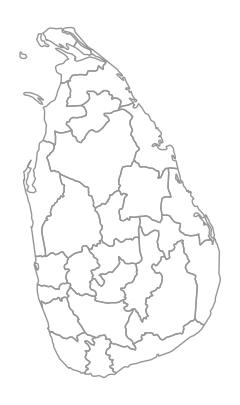

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
zones.plot(
    ax=ax,
    facecolor='none',
    edgecolor='#969696')
ax.set_aspect('equal')
ax.set_axis_off()
plt.show()

Next we read the Yearly Night-time Lights Rasters and create an Xarray Dataset.

In [18]:
start_year = 2015
end_year = 2020

data_folder = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'

da_list = []

for year in range(start_year, end_year + 1):
  cog_url = f'{data_folder}/{year}.tif'
  da = rxr.open_rasterio(
      cog_url,
      chunks=True).rio.clip_box(*bbox)
  dt = pd.to_datetime(year, format='%Y')
  da = da.assign_coords(time = dt)
  da = da.expand_dims(dim="time")
  da_list.append(da)

In [19]:
ntl_datacube = xr.concat(da_list, dim='time').chunk('auto')
ntl_datacube

<xarray.DataArray (time: 6, band: 1, y: 870, x: 498)> Size: 10MB
dask.array<rechunk-merge, shape=(6, 1, 870, 498), dtype=float32, chunksize=(6, 1, 870, 498), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 48B 2015-01-01 2016-01-01 ... 2020-01-01
  * band         (band) int64 8B 1
  * y            (y) float64 7kB 9.828 9.823 9.819 9.814 ... 5.933 5.929 5.924
  * x            (x) float64 4kB 79.66 79.66 79.66 79.67 ... 81.88 81.88 81.89
    spatial_ref  int64 8B 0
Attributes:
    DataType:            Generic
    AREA_OR_POINT:       Area
    BandName:            Band_1
    RepresentationType:  ATHEMATIC
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           Band_1
    _FillValue:          0.0

Since all the rasters have a single band of information, we select the first band and drop that dimension.

In [20]:
ntl_datacube = ntl_datacube.sel(band=1, drop=True)
ntl_datacube

<xarray.DataArray (time: 6, y: 870, x: 498)> Size: 10MB
dask.array<getitem, shape=(6, 870, 498), dtype=float32, chunksize=(6, 870, 498), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 48B 2015-01-01 2016-01-01 ... 2020-01-01
  * y            (y) float64 7kB 9.828 9.823 9.819 9.814 ... 5.933 5.929 5.924
  * x            (x) float64 4kB 79.66 79.66 79.66 79.67 ... 81.88 81.88 81.89
    spatial_ref  int64 8B 0
Attributes:
    DataType:            Generic
    AREA_OR_POINT:       Area
    BandName:            Band_1
    RepresentationType:  ATHEMATIC
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           Band_1
    _FillValue:          0.0

## Zonal Stats

Now we will extract the sum of the raster pixel values for every admin1 region in the selected countrey.

First, we need to convert the GeoDataFrame to a Xarray Dataset. We will be using the `regionmask` module that converts the geodataframe into an Xarray Dataset having dimension and coordinates same as of given input xarray dataset.

In [21]:
# Create mask of multiple regions from shapefile
mask = regionmask.mask_3D_geopandas(
        zones,
        ntl_datacube.x,
        ntl_datacube.y,
        drop=True,
        numbers='id',
        overlap=True
    )

Apply the mask on the dataset.

In [23]:
ntl_datacube = ntl_datacube.where(mask).chunk('auto')
ntl_datacube

<xarray.DataArray (time: 6, y: 870, x: 498, region: 25)> Size: 260MB
dask.array<rechunk-merge, shape=(6, 870, 498, 25), dtype=float32, chunksize=(5, 747, 426, 21), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 48B 2015-01-01 2016-01-01 ... 2020-01-01
  * y            (y) float64 7kB 9.828 9.823 9.819 9.814 ... 5.933 5.929 5.924
  * x            (x) float64 4kB 79.66 79.66 79.66 79.67 ... 81.88 81.88 81.89
  * region       (region) int64 200B 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25
    spatial_ref  int64 8B 0
Attributes:
    DataType:            Generic
    AREA_OR_POINT:       Area
    BandName:            Band_1
    RepresentationType:  ATHEMATIC
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           Band_1
    _FillValue:          0.0

Next we calculate zonal statistics on the masked DataArray. Here we want the sum of nighttime lights within each region for each year, so we group by `time` and `sum` of all pixels values within each region.

In [24]:
grouped = ntl_datacube.groupby('time').sum(['x','y'])
grouped

<xarray.DataArray (time: 6, region: 25)> Size: 600B
dask.array<getitem, shape=(6, 25), dtype=float32, chunksize=(1, 21), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 48B 2015-01-01 2016-01-01 ... 2020-01-01
  * region       (region) int64 200B 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25
    spatial_ref  int64 8B 0
Attributes:
    DataType:            Generic
    AREA_OR_POINT:       Area
    BandName:            Band_1
    RepresentationType:  ATHEMATIC
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           Band_1
    _FillValue:          0.0

Compute the result. Dask will now distribute the computation across all chunks using available workers.

In [ ]:
%time grouped = grouped.compute()

Conver the results to a Pandas DataFrame. We now have total of nighttime lights values for each region for each zone.

In [35]:
stats = grouped.drop_vars('spatial_ref').to_dataframe('sum').reset_index()
stats.head()

,time,region,sum
0,2015-01-01,1,449.778412
1,2015-01-01,2,49.645641
2,2015-01-01,3,891.009949
3,2015-01-01,4,100.430511
4,2015-01-01,5,27.500204


Add a `year` column and rename the `region` to `id` so we can join it back to the original shapefile.

In [34]:
stats['year'] = stats.time.dt.year
stats = stats.rename(columns={'region': 'id'})
stats.head()

,time,id,sum,year
0,2015-01-01,1,449.778412,2015
1,2015-01-01,2,49.645641,2015
2,2015-01-01,3,891.009949,2015
3,2015-01-01,4,100.430511,2015
4,2015-01-01,5,27.500204,2015


Performa table join to merge the results with the original zones GeoDataFrame.

In [33]:
results = zones.merge(stats, on='id')
results.head()

,adm1_code,name,iso_a2,geometry,id,time,sum,year
0,LKA-2454,Trikuṇāmalaya,LK,"POLYGON ((80.92292 8.98892, 80.92319 8.97321, ...",1,2015-01-01,449.778412,2015
1,LKA-2454,Trikuṇāmalaya,LK,"POLYGON ((80.92292 8.98892, 80.92319 8.97321, ...",1,2016-01-01,453.339569,2016
2,LKA-2454,Trikuṇāmalaya,LK,"POLYGON ((80.92292 8.98892, 80.92319 8.97321, ...",1,2017-01-01,640.339172,2017
3,LKA-2454,Trikuṇāmalaya,LK,"POLYGON ((80.92292 8.98892, 80.92319 8.97321, ...",1,2018-01-01,656.189758,2018
4,LKA-2454,Trikuṇāmalaya,LK,"POLYGON ((80.92292 8.98892, 80.92319 8.97321, ...",1,2019-01-01,854.694946,2019


Finally, we save the result to disk.

In [32]:
output = results[['adm1_code', 'name', 'iso_a2', 'year', 'sum']]
output.head()

,adm1_code,name,iso_a2,year,sum
0,LKA-2454,Trikuṇāmalaya,LK,2015,449.778412
1,LKA-2454,Trikuṇāmalaya,LK,2016,453.339569
2,LKA-2454,Trikuṇāmalaya,LK,2017,640.339172
3,LKA-2454,Trikuṇāmalaya,LK,2018,656.189758
4,LKA-2454,Trikuṇāmalaya,LK,2019,854.694946


In [31]:
output_file = 'output.csv'
output_path = os.path.join(output_folder, output_file)

output.to_csv(output_path, index=False)
print('Successfully written output file at {}'.format(output_path))

Successfully written output file at output/output.csv


----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>